In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-08-01 14:42


In [2]:
import json
import glob
import os

import urllib.parse
import urllib.request

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

## Placing the Spongilla proteome in context

Genes don't do shit. They just sit on the genome. Proteins, on the other hand, do shit. When doing molecular biology with an organism we often treat proteins as the important agents that perform a function, and we often merge in our minds the proteins that arise from a gene and the gene itself.

It is super important, then, to know what proteins do. Unfortunately, it is not possible to conduct experiments for all proteins in all organisms. We know that many proteins (genes) are shared between species (were present in the last common ancestor) and we even have evidence that they still perform the same function. Generalizing from this, we figure that if proteins are much more similar to each other than chance would allow, they probably have very similar structures and perform very similar (if not identical) functions.

People have used sequence similarity to do this with great success. In fact, in the year of our Lord 2022, when working with a non-model species it is standard procedure to use a sequence similarity search against well-annotated proteomes (such as human/fly/mouse/worm) and transfer the functional annotations where the sequence similarity is above a certain threshold. Sadly, the model species represent a very narrow subset of animal life, let alone life in general. When working with more exotic species, the portion of genes that are annotated this way is rather low.

Consider the _Spongilla lacustris_ proteome:

In [3]:
# Multiple sequence alignments
sequence_info = pd.read_csv('../data/sequence_info.csv', index_col='query')

In [4]:
len(sequence_info), len(sequence_info['gene_id'].unique())

(41943, 29664)

The reasonable transcriptome assembly of _Spongilla_ has ~42k predicted peptides from ~30k predicted genes. If we use a state-of-the-art sequence-based annotation pipeline like [EggNOG](http://eggnog5.embl.de/), the results are somewhat OK:

In [5]:
# sequence-based annotation (emapper)
sequence_annotation = pd.read_csv('../data/Slacustris_eggnog.tsv', sep='\t')

In [6]:
len(sequence_annotation), np.sum(sequence_annotation['Description'] != "-")

(17990, 17394)

Close to 18k (so ~42%) of this transcriptome gets _some_ sort of annotation, and about 41% gets a description. This means that we have some idea about their function (but no specifics) or, at the very least, that these genes could at least be assigned to a group of orthologous genes, even though nothing might be known about them. Think about this: we have no reasonable information about 60% of the _Spongilla_ proteome!

In [7]:
np.sum(sequence_annotation['Preferred_name'] != "-")

12673

On the other hand, ~13k (predicted) proteins get a name; this is close to one third (30%) of the proteome. This reflects the historical choice of model species, with a focus on bilaterians/chordates; the Big Four model species (aqua), or organisms that can be reliably mapped to them, enjoy much higher rates of annotation than poriferans (orange) or other taxonomically challenging species.

|organism|%described|%named|
|---|---|---|
| <span style='background: aqua'>Homo sapiens</span> | 96.43% | 94.91% |
| <span style='background: aqua'>Mus musculus</span> | 96.39% | 90.48% |
| Danio rerio | 94.02% | 76.98% |
| Saccharomyces cerevisiae | 90.82% | 59.22% |
| Arabidopsis thaliana | 85.36% | 7.96% |
| <span style='background: aqua'>Drosophila melanogaster</span> | 82.55% | 52.80% |
| Trichoplax adhaerens | 80.45% | 53.09% |
| Strongylocentrotus purpuratus | 79.90% | 47.02% |
| Branchiostoma floridae | 76.50% | 46.43% |
| Nematostella vectensis | 71.77% | 39.38% |
| <span style='background: aqua'>Caenorhabditis elegans</span> | 70.58% | 31.68% |
| Ciona intestinalis | 66.64% | 54.19% |
| Dictyostelium discoideum | 61.07% | 2.92% |
| Octopus vulgaris | 60.36% | 46.51% |
| <span style='background: orange'>Amphimedon queenslandica</span> | 58.63% | 25.47% |
| Helobdella robusta | 58.45% | 37.26% |
| Stylophora pistillata | 56.87% | 32.50% |
| Lottia gigantea | 50.85% | 39.07% |
| Clytia hemisphaerica | 45.81% | 31.97% |
| <span style='background: yellow'>S_lacustris</span> | ~41% | ~30% |
| <span style='background: orange'>Ephydatia muelleri</span> | 40.01% | 20.67% |
| Ramazzottius varieornatus | 35.58% | 28.60% |

In [8]:
max_annot_lvl = pd.read_csv('../data/max_annot_lvl_count.tsv', sep='\t', header=None)
max_annot_lvl.columns = ['max_annot_lvl', 'general']

In [9]:
sequence_annotation = sequence_annotation.merge(max_annot_lvl, on='max_annot_lvl', how='left')

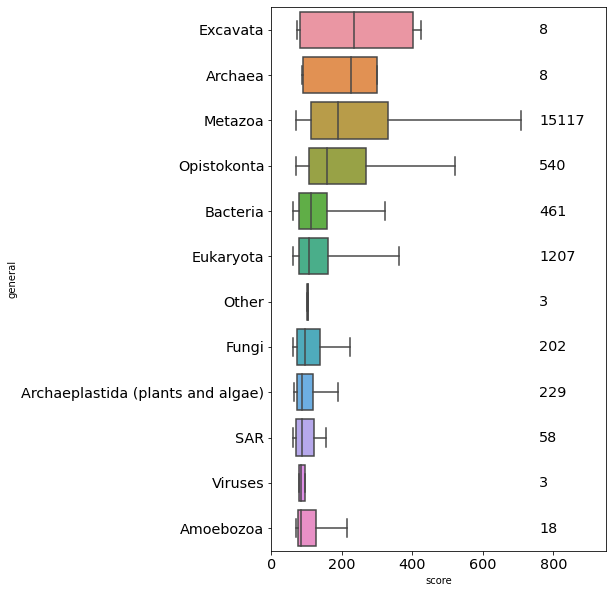

In [10]:
fig, ax = plt.subplots(figsize=(6, 10))
ordered = sequence_annotation[['general', 'score']].groupby('general').apply(np.median).sort_values(ascending=False).index
counts = sequence_annotation.groupby(['general']).apply(len)
b = sns.boxplot(data=sequence_annotation, y='general', x='score', ax=ax, fliersize=0, order=ordered, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(760, i+0.1, str(c), fontsize='x-large')
ax.set_xlim(0, 950)
b.tick_params(labelsize='x-large');
# ax.set_title('maximal annotation level bit score');
plt.savefig('./figures/analysis-sequence_annotation_taxonomic_level.pdf')

We'd like to do better than that. It is clear that with the sequence-based approach we hit a wall, since sponges are so far diverged from the organisms we have reliable functional info for. It has long been accepted conventional wisdom that structure is more conserved than function. If we used structural similarity we might be able to detect very remote homologies that are not detectable on the sequence level. For a very long time this was an impractical approach since the generation of protein structures was a very expensive, time-consuming, and labor-intensive process. However, the recent advances in structure prediction (AlphaFold) and structure search (FoldSeek) make this pipe dream possible!

## Introducing AlphaFold

We used AlphaFold (ColabFold) to predict structures for the predicted proteome of _Spongilla lacustris_. To get a sense for how well it worked we compare AlphaFold performance in _Spongilla_ with its performance for some other species:

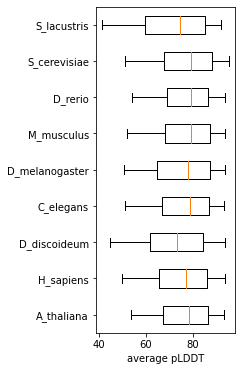

In [11]:
annotation = {}
predicted_proteomes = ['A_thaliana', 'H_sapiens', 'D_discoideum', 'C_elegans',
                       'D_melanogaster', 'M_musculus', 'D_rerio', 'S_cerevisiae']

# read the AlphaFold average pLDDT scores
for animal in predicted_proteomes:
    annotation[animal] = pd.read_csv('../data/alphafold_performance/' + animal + '.tsv', sep='\t')

# convert to a list of arrays so we can make a boxplot
animal_plddt = [annotation[f]['plddt'].values for f in annotation]
# add Spongilla to that list
alphafold = pd.read_csv('../data/structure_predictions.csv', index_col=0)
animal_plddt.append(alphafold['plddt'].values)

animal_names = list(annotation) + ['S_lacustris']

fig, ax = plt.subplots(figsize=(2.5, 6))
ax.boxplot(animal_plddt, labels=animal_names, sym='', vert=False, whis=[5, 95]);
ax.set_xlabel('average pLDDT')
plt.savefig('./figures/analysis-alphafold_other_species.pdf')

The _Spongilla_ proteome, while slightly worse in average, largely contains predicted protein structures of the same quality as other species.

## Introducing FoldSeek

We used FoldSeek to align the predicted structures against PDB, SwissProt, and AlphaFoldDB. We obtained UniProt IDs for each FoldSeek target hit, and queried the annotation of these targets. We kept the best-scoring annotated hit for each Spongilla protein in each database. We wondered if there was any relationship between the quality of the FoldSeek match (i.e. the bit score of the alignment) and the quality of the predicted structure (the pLDDT score of the _Spongilla_ protein). We focused on the aligned regions. Essentially we ask: what regions is  FoldSeek primarily working with?

In [12]:
pdb = pd.read_parquet('../data/fs_best_pdb.parquet')
afdb = pd.read_parquet('../data/fs_best_afdb.parquet')
swp = pd.read_parquet('../data/fs_best_swp.parquet')

There is too much information so we're going to bin the FoldSeek aligned region scores into buckets (see also [AlphaFold's FAQ](https://alphafold.ebi.ac.uk/faq#faq-5)):

- pLDDT > 90: excellent quality, close to crystal structure/cryoEM
- 70 < pLDDT < 90: good quality (good backbone prediction)
- 50 < pLDDT < 70 low confidence, treat with caution.
- pLDDT < 50 reasonably assumed to be disordered, i.e. it suggests such a region is either unstructured in physiological conditions or only structured as part of a complex.

In [13]:
pdb['aligned_buckets'] = pd.cut(pdb['aligned_plddt'], bins=[0, 50, 70, 90, 100])
afdb['aligned_buckets'] = pd.cut(afdb['aligned_plddt'], bins=[0, 50, 70, 90, 100])
swp['aligned_buckets'] = pd.cut(swp['aligned_plddt'], bins=[0, 50, 70, 90, 100])

concatenate into a big flat matrix (_a la_ ggplot2):

In [14]:
keep = ['query', 'aligned_buckets', 'bit score', 'aligned_plddt']
pdb_subset = pdb[keep].copy()
pdb_subset['origin'] = 'PDB'
afdb_subset = afdb[keep].copy()
afdb_subset['origin'] = 'AFDB'
swp_subset = swp[keep].copy()
swp_subset['origin'] = 'SwissProt'

In [15]:
big = pd.concat([pdb_subset, afdb_subset, swp_subset])

Split by bin, color by origin. Figure has been adjusted manually to highlight counts per bin.

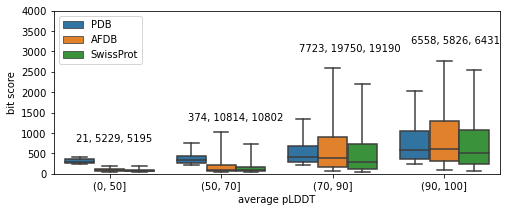

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=big, x='aligned_buckets', y='bit score', hue='origin', fliersize=0, ax=ax, whis=[5, 95])
ax.set_ylim(0, 4000)

counts = big.groupby(['aligned_buckets', 'origin']).apply(len)
count_height = [800, 1300, 3000, 3200]
for i, bucket in enumerate(big['aligned_buckets'].cat.categories):
    ordered_counts = counts[bucket][['PDB', 'AFDB', 'SwissProt']].astype(str).values
    string = ', '.join(ordered_counts)
    ax.text(i-0.3, count_height[i], string)
    
ax.legend();
ax.set_xlabel('average pLDDT')
plt.savefig('./figures/analysis-spongilla_af_pLDDT_vs_bit_score.pdf')

FoldSeek is generally more confident for peptides with high-quality structure prediction. This is expected.

However, even peptides with lower confidence structures find very, very good structural analogs in the three databases we queried.

## Building a FoldSeek-based gene annotation table

In the next step we merged the partial results from each database to form a single table, where each _Spongilla_ protein is matched with the most similar annotated structure across all of the available structure space.

In [17]:
structural_annotation = pd.read_parquet('../data/structure_annotation.parquet')

We will have a look at the distribution of (log) bit scores to understand a bit better:

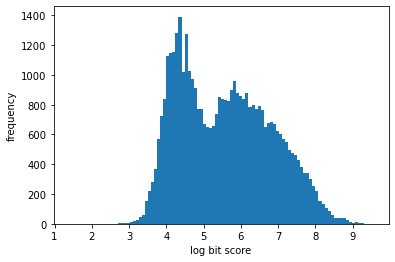

In [18]:
fig, ax = plt.subplots()
ax.hist(np.log(structural_annotation['bit score']), bins=100);
ax.set_xlabel('log bit score')
ax.set_ylabel('frequency');

A clear bimodal distribution appears, with the two underlying distributions mixing at ~$\log(bit score) = 5$. We'd like to keep the high quality predictions, so we'll set the threshold at $e^5$, approximately a bit score of 150.

In [19]:
bitscore_cut_off = np.exp(5)

In [20]:
np.sum(structural_annotation['bit score'] >= bitscore_cut_off), len(structural_annotation)

(25232, 41943)

We'd end up with about 25000 peptides annotated. This is about 60% of the predicted proteome, already much better than the initial 40% we started with.

In [21]:
keep = structural_annotation['bit score'] >= bitscore_cut_off
structural_annotation = structural_annotation[keep].copy()

### Getting to know FoldSeek: taxonomic distribution

We next asked whether and how the taxonomic level of the FoldSeek annotation influenced the FoldSeek score; we'd expect hits from taxonomically close neighbors to have higher average bit scores. Longer evolutionary distances should also mean higher divergence in structure.

For visualisation reasons we'll only show taxonomic groups that contributed at least 50 proteins.

In [22]:
taxonomy = pd.read_csv('../data/max_annot_lvl_count.tsv', sep='\t', header=None)
taxonomy.columns = ['max_annot_lvl', 'eggnog_max_taxonomy']

structural_annotation = structural_annotation.merge(taxonomy, on='max_annot_lvl', how='left')

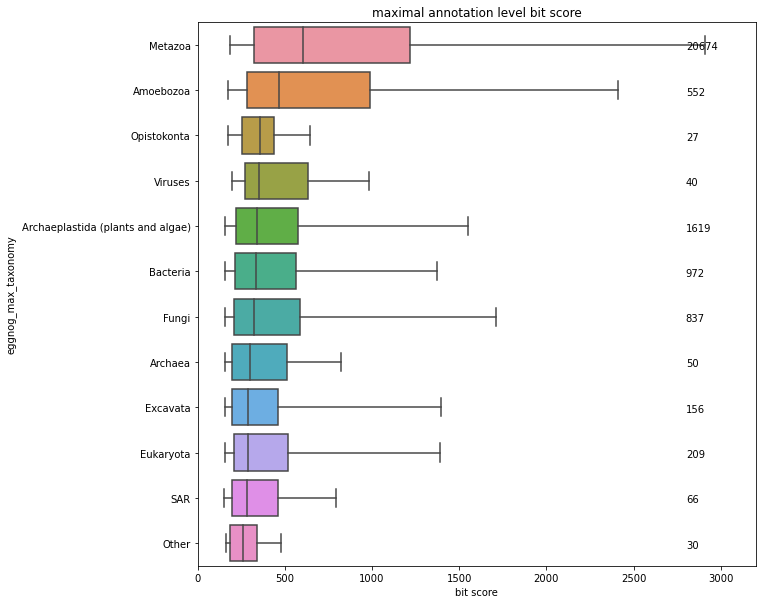

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ordered = structural_annotation[['eggnog_max_taxonomy', 'bit score']].groupby('eggnog_max_taxonomy').apply(np.median).sort_values(ascending=False).index
counts = structural_annotation.groupby(['eggnog_max_taxonomy']).apply(len)
sns.boxplot(data=structural_annotation, y='eggnog_max_taxonomy', x='bit score', ax=ax, fliersize=0, order=ordered, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(2800, i+0.1, str(c))
ax.set_xlim(0, 3200)
ax.set_title('maximal annotation level bit score');
plt.savefig('./figures/analysis-structure_annotation_taxonomic_level.pdf')

Most hits come from Metazoa, and they also have the best bit scores by far. The only other group with clearly high scores are amoebozoa, a group with problematic taxonomy. It is very interesting to see how many genes are contributed by plants, fungi, and bacteria. What are these proteins?

* lost in other animal lineages but present in the common ancestor, and therefore only visible in sponges and unicellular organisms?
* present in animals, just not in the ones currently in the database?
* present in animals and in the database but the most similar structures come from non-metazoan species?
* sponge innovations with structural analogs in unicellular organisms?
* sponge symbiont proteins that were accidentally sequenced? Remember, this is a transcriptome, so we don't have the extra safety of the genomic scaffold.

Next up, we are going to look at the same question but use the UniProt taxonomic lineage instead:

In [24]:
taxonomy = pd.read_csv('../data/tax_count.tsv', sep='\t', header=None)
taxonomy.columns = ['Taxonomic lineage (PHYLUM)', 'UniProt detailed', 'UniProt coarse']

structural_annotation = structural_annotation.merge(taxonomy, on='Taxonomic lineage (PHYLUM)', how='left')

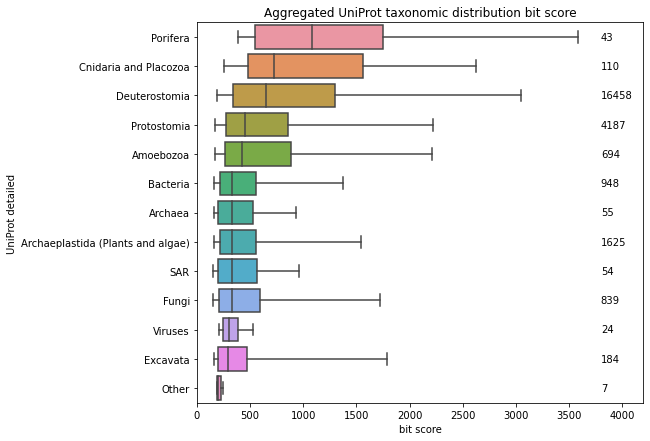

In [25]:
fig, ax = plt.subplots(figsize=(8, 7))
ordered = structural_annotation[['UniProt detailed', 'bit score']].groupby('UniProt detailed').apply(np.median).sort_values(ascending=False).index
counts = structural_annotation.groupby(['UniProt detailed']).apply(len)
sns.boxplot(data=structural_annotation, y='UniProt detailed', x='bit score', ax=ax, fliersize=0, order=ordered, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(3800, i+0.1, str(c))
ax.set_xlim(0, 4200);
ax.set_title('Aggregated UniProt taxonomic distribution bit score');
plt.savefig('./figures/analysis-structure_annotation_taxonomic_level_detailed.pdf')

We see that many of the best FoldSeek hits come from metazoan groups. This is not particularly surprising; in fact, it's validating. What is surprising, however, is to see just how many best hits come from plants and unicellular organisms. What could this mean?

Finally, we are going to see how the structural similarity behaves if we split proteins by their coarse-grained function:

In [26]:
to_replace = {
    'A': 'A-RNA processing and modification',
    'B': 'B-Chromatin Structure and dynamics',
    'C': 'C-Energy production and conversion',
    'D': 'D-Cell cycle control and mitosis',
    'E': 'E-Amino Acid metabolis and transport',
    'F': 'F-Nucleotide metabolism and transport',
    'G': 'G-Carbohydrate metabolism and transport',
    'H': 'H-Coenzyme metabolis',
    'I': 'I-Lipid metabolism',
    'J': 'J-Translation',
    'K': 'K-Transcription',
    'L': 'L-Replication and repair',
    'M': 'M-Cell wall/membrane/envelope biogenesis',
    'N': 'N-Cell motility',
    'O': 'O-Post-translational modification, protein turnover, chaperone functions',
    'P': 'P-Inorganic ion transport and metabolism',
    'Q': 'Q-Secondary Structure',
    'T': 'T-Signal Transduction',
    'U': 'U-Intracellular trafficking and secretion',
    'Y': 'Y-Nuclear structure',
    'Z': 'Z-Cytoskeleton',
    'R': 'R-General Functional Prediction only',
    'S': 'S-Function Unknown '
}

# structural_annotation['COG_category'].replace(to_replace=to_replace, inplace=True)

There will be many COG categories that only represent a couple of genes; we don't want to visualize those because of the clutter.

In [27]:
def find_acceptable(df, field, cutoff):
    acceptable = df[field].value_counts()[df[field].value_counts() > cutoff].index.values
    keep = df[field].isin(acceptable)
    return keep, acceptable

In [28]:
acceptable = structural_annotation['COG_category'].value_counts()[structural_annotation['COG_category'].value_counts() > 50].index.values
keep = structural_annotation['COG_category'].isin(acceptable)

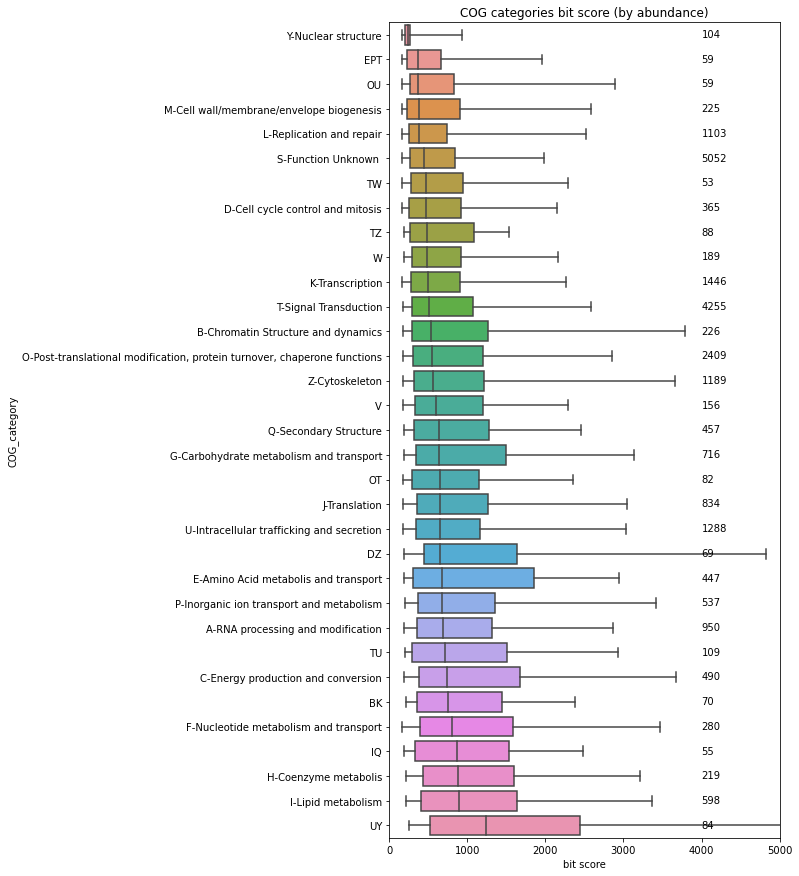

In [29]:
fig, ax = plt.subplots(figsize=(7, 15))
counts = structural_annotation.replace(to_replace=to_replace)[keep].groupby(['COG_category']).apply(len)
ordered = structural_annotation.replace(to_replace=to_replace)[keep][['COG_category', 'bit score']].groupby('COG_category').apply(np.median).sort_values().index
sns.boxplot(data=structural_annotation[keep].replace(to_replace=to_replace), y='COG_category', x='bit score', ax=ax, fliersize=0, order=ordered, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(4000, i+0.1, str(c))
ax.set_xlim(0, 5000)
ax.set_title('COG categories bit score (by abundance)');
plt.savefig('./figures/analysis-structure_annotation_cog_categories.pdf')

## Comparing to sequence-based annotation:

Refer to `suppl-struct_seq_agreement.ipynb`

In [30]:
annotation_status = pd.read_csv('../data/annotation_status.tsv', sep='\t')
with_sequence = structural_annotation.merge(annotation_status, on='protein_id')

Let's see how good FoldSeek does on the surface. For consistent plotting, let's set up our reference here:

In [31]:
color_reference = {
    'Specific OG\nsame name': cm.tab20.colors[0],
    'Specific OG': cm.tab20.colors[0],
    'Root OG\nsame name': cm.tab20.colors[18],
    'Root OG': cm.tab20.colors[18],
    '50% PFAM\nsame name': cm.tab20.colors[16],
    '50% PFAM': cm.tab20.colors[16],
    'no agreement': cm.Set3.colors[6],
    'no seq. annot.': cm.Set3.colors[7],
    'no CoFFE annot.': cm.Set3.colors[5]
}

patterns = ['...', '', '...', '', '...', '', '', '', '']

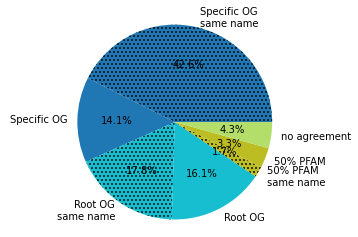

In [32]:
order = ['Specific OG\nsame name', 'Specific OG',
         'Root OG\nsame name', 'Root OG',
         '50% PFAM\nsame name', '50% PFAM',
         'no agreement']
vc = with_sequence['annotation status'].value_counts()[order]
labels = vc.index
sizes = vc.values
colors = [color_reference[i] for i in labels]
# explode = (0.1, 0, 0, 0, 0)

fig, ax = plt.subplots()
piechart = ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, colors=colors)
ax.axis('equal');

for i, p in enumerate(piechart[0]):
    p.set_hatch(patterns[i])

plt.savefig('./figures/analysis-sequence_structure_agreement.pdf')

Overall, close to 90% of the proteins find a FoldSeek hit in the same family or general functional category as the sequence annotation. This means that we can largely trust FoldSeek!

Let's see how we do overall - does FoldSeek generally annotate the known proteins better than the unknown ones?

In [33]:
structural_annotation = structural_annotation.merge(annotation_status, on='protein_id', how='left')
structural_annotation['annotation status'].fillna('no seq. annot.', inplace=True)

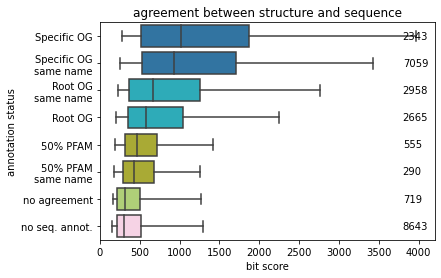

In [34]:
fig, ax = plt.subplots()
ordered = structural_annotation[['annotation status', 'bit score']].groupby('annotation status').apply(np.median).sort_values(ascending=False).index
counts = structural_annotation.groupby(['annotation status']).apply(len)
bar = sns.boxplot(data=structural_annotation, x='bit score', y='annotation status', fliersize=0, ax=ax, order=ordered, palette=color_reference, whis=[5, 95])
for i, b in enumerate(bar.patches):
    b.set_hatch(patterns[i])
for i, c in enumerate(counts[ordered].values):
    ax.text(3800, i+0.1, str(c))
ax.set_xlim(0, 4200)
ax.set_title('agreement between structure and sequence');
plt.savefig('./figures/analysis-sequence_structure_agreement_by_bit_score.pdf')

FoldSeek performs clearly better for proteins that we can confidently identify based on their sequence. This is not very surprising. It is interesting that proteins that have no sequence annotation have the same distribution as proteins whose structural annotation disagrees with the sequence-based one. How does AlphaFold perform though? Is it the same?

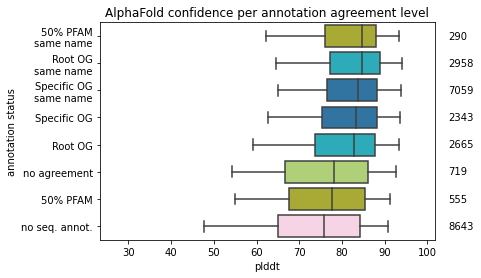

In [35]:
fig, ax = plt.subplots()
ordered = structural_annotation[['annotation status', 'plddt']].groupby('annotation status').apply(np.median).sort_values(ascending=False).index
counts = structural_annotation.groupby(['annotation status']).apply(len)
sns.boxplot(data=structural_annotation, x='plddt', y='annotation status', fliersize=0, ax=ax, order=ordered, palette=color_reference, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(105, i+0.1, str(c))
# ax.set_xlim(0, 120)
ax.set_title('AlphaFold confidence per annotation agreement level');
plt.savefig('./figures/analysis-sequence_structure_agreement_by_pLDDT.pdf')

Different result here: EggNOG orthogroup cases are clearly better than the rest, but not as clearly as before. Also, proteins that disagree with the sequence annotation (and even proteins without sequence annotation!) have better average than those who agree on COG category.

Similarly, if we split up the results by AlphaFold confidence buckets, what do the distributions look like?

In [36]:
structural_annotation['plddt_buckets'] = pd.cut(structural_annotation['plddt'], bins=[0, 50, 70, 90, 100])

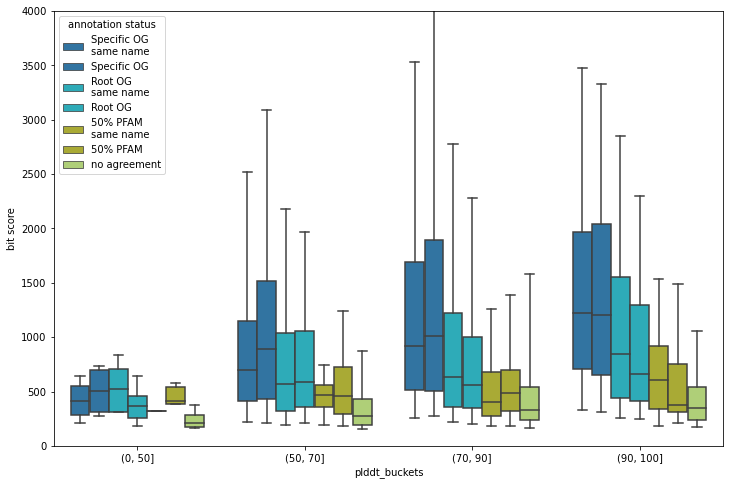

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
# order = ['no seq. annot.', 'no agreement', 'COG category', '50% PFAM', 'Root OG', 'Specific OG']
sns.boxplot(data=structural_annotation, x='plddt_buckets', y='bit score', hue='annotation status',
            palette=color_reference, ax=ax, fliersize=0, hue_order=order, whis=[5, 95])
ax.set_ylim(0, 4000);
plt.savefig('./figures/analysis-sequence_structure_agreement_pLDDT_vs_bit_score.pdf')

There are three broad things we can notice here

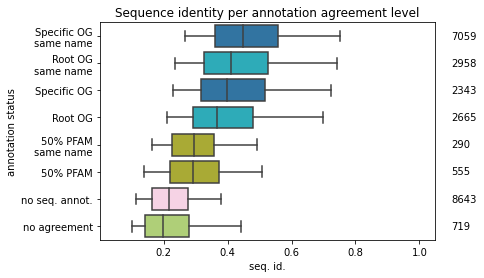

In [38]:
fig, ax = plt.subplots()
ordered = structural_annotation[['annotation status', 'seq. id.']].groupby('annotation status').apply(np.median).sort_values(ascending=False).index
counts = structural_annotation.groupby(['annotation status']).apply(len)
sns.boxplot(data=structural_annotation, x='seq. id.', y='annotation status', fliersize=0, ax=ax, order=ordered, palette=color_reference, whis=[5, 95])
for i, c in enumerate(counts[ordered].values):
    ax.text(1.1, i+0.1, str(c))
# ax.set_xlim(0, 120)
ax.set_title('Sequence identity per annotation agreement level');
plt.savefig('./figures/analysis-sequence_structure_agreement_by_seq_id.pdf')

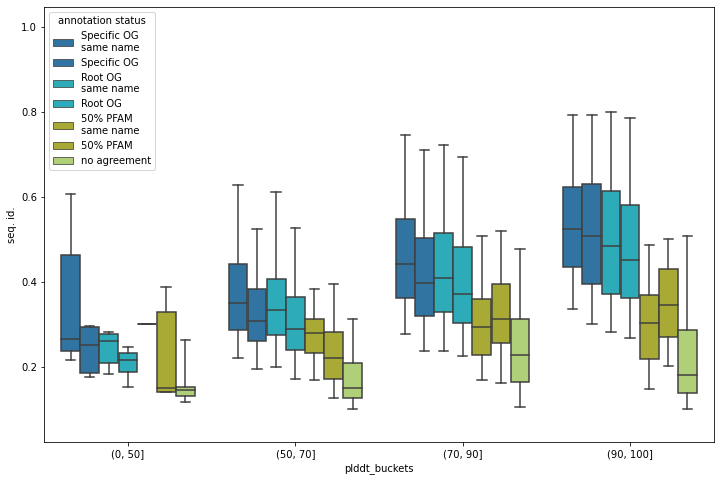

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
# order = ['no seq. annot.', 'no agreement', 'COG category', '50% PFAM', 'Root OG', 'Specific OG']
sns.boxplot(data=structural_annotation, x='plddt_buckets', y='seq. id.', hue='annotation status',
            palette=color_reference, ax=ax, fliersize=0, hue_order=order, whis=[5, 95])
# ax.set_ylim(0, 4000);
plt.savefig('./figures/analysis-sequence_structure_agreement_pLDDT_vs_seq_id.pdf')